In [1]:
!pip install tf-nightly-gpu-2.0-preview==2.0.0.dev20190520
import tensorflow as tf
tf.random.set_seed(1234)

!pip install tfds-nightly
import tensorflow_datasets as tfds

import os
import re
import numpy as np

import matplotlib.pyplot as plt

     |████████████████████████████████| 349.0MB 53kB/s 
     |████████████████████████████████| 61kB 24.5MB/s 
     |████████████████████████████████| 440kB 49.8MB/s 
     |████████████████████████████████| 3.1MB 36.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
  Found existing installation: wrapt 1.10.11
    Uninstalling wrapt-1.10.11:
      Successfully uninstalled wrapt-1.10.11


### 准备数据
我们使用电影和电视剧中的对话数据集[Cornell Movie-Dialogs Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html)。这个数据集包含了1万对以上的电影角色提供的超过22万个对话。

<code>movie_conversations.txt</code>包含了对话ID的列表。<code>movie_lines.txt</code>包含了各个对话ID的对话文本。更多信息请阅读zip文件中的README。

In [2]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin=
    'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,
                                           'movie_conversations.txt')

9920512/9916637 [==============================] - 2s 0us/step


### 读取数据以及预处理
为了保持本教程的简洁，我们限定训练样本的最大数量为<code>toMAX_SAMPLES=25000</code>以及句子的最大长度为<code>MAX_LENGTH=40</code>

我们的预处理有以下几个步骤
* 解压<code>MAX_SAMPLES</code>组的对话，放入问题和回答的各个列表。
* 通过删除特殊字符来预处理每个句子
* 建立分词器（text2id和id2text），使用[TensorFlow Datasets SubwordTextEncoder.](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder)。
* 对每个句子进行分词，然后添加<code>START_TOKEN</code>和<code>END_TOKEN</code>.来表示首尾。
* 对超过<code>MAX_LENGTH</code>的句子进行过滤。
* Pad过短的句子使其长度达到<code>MAX_LENGTH</code>

In [0]:
# 样本最大数量
MAX_SAMPLES = 50000

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # 在标点符号前后添加空格
    # eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 把其余的东西全部替换为空格 (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    # 添加起始符和终止符
    return sentence


def load_conversations():
    # id2line字典
    id2line = {}
    with open(path_to_movie_lines, errors='ignore') as file:
        # eg: L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!
        lines = file.readlines()
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        id2line[parts[0]] = parts[4]

    inputs, outputs = [], []
    with open(path_to_movie_conversations, 'r') as file:
        # eg: u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']
        lines = file.readlines()
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        # 把对话转换成line id的列表
        conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
        for i in range(len(conversation) - 1):
            inputs.append(preprocess_sentence(id2line[conversation[i]]))
            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
            if len(inputs) >= MAX_SAMPLES:
                return inputs, outputs
    return inputs, outputs


questions, answers = load_conversations()

In [4]:
print('Sample question: {}'.format(questions[20]))
print('Sample answer: {}'.format(answers[20]))

Sample question: i really , really , really wanna go , but i can t . not unless my sister goes .
Sample answer: i m workin on it . but she doesn t seem to be goin for him .


In [0]:
# 使用tfds建立分词起词用于问题和回答
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# 定义起始符和终止符
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 词典大小（增加了起始符和终止符）
VOCAB_SIZE = tokenizer.vocab_size + 2

In [6]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [4, 281, 3, 281, 3, 143, 395, 176, 3, 42, 4, 38, 8191, 2, 37, 873, 27, 2031, 3096, 1]


In [0]:
# 最大句子长度
MAX_LENGTH = 40


# 分词，过滤和pad
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 对句子进行分词
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        # 检查句子长度
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 对分词后的句子pad
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [8]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))

Vocab size: 8333
Number of samples: 44095


### 建立tf.data.Dataset
我们将使用[tf.data.Dataset API](https://www.tensorflow.org/api_docs/python/tf/data)来构建输入pipline以便能够利用类似缓存和预加载的特性来加速训练过程。

Transformer是一个自回归模型：它对每个时刻作出预测，并且使用之前的输出来决定之后的行为。

在训练阶段本教程使用tearcher-forcing：teacher-forcing会向下一个时刻传递真实的输出，无论模型当前时刻的预测是什么。

Transformer预测每个单词时，self-attention允许它查看输入序列中当前单词之前的单词，以便更好的预测下一个单词。

为了防止模型偷看之后的输出，我们在模型中使用look-ahead mask。

Target被分成了decoder_inputs（pad成decoder的输入）和cropped_targets（用来计算loss和准确度）

In [9]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# decoder的输入使用之前的target
# 从targets中删除START_TOKEN
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


W0607 06:01:17.916875 139909170698112 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
print(dataset)

<PrefetchDataset shapes: ({inputs: (None, 40), dec_inputs: (None, 39)}, {outputs: (None, 39)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


### Attention
#### Scaled dot product Attetion
Transformer中使用的scaled dot product Attetion接受3个输入：Q(query), K(key), V(value). 用来计算Attention权重的式子可写成：

$$Attetnion(Q, K, V)=softmax_k(\frac{QK^T}{\sqrt{d_k}})V$$

对key进行softmax标准化后的数值决定了其query的重要程度。

式子的输出是attention权重和value向量的乘积。这保证了我们想关注的单词信息会被保留下来并且无关的单词信息会被冲走。

通过除上深度的平方根来缩小dot product Attetion。因为如果深度很大，那么dot product增长的量级也很大。这会迫使softmax方程使其拥有很小的梯度从而导致了hard softmax。

举个例子，假定query和key有0均值和1方差。他们的矩阵乘积会有0均值和dk方差。因此，dk的平方根用来缩小输出是为了让query和key的矩阵乘积也能拥有0均值和1方差，这样我们就有了一个相对好处理的softmax。

mask会被乘上-1e9（接近负无穷）。这么做是因为我们会在softmax之前合计mask和缩小后的query和key的矩阵乘积值。目的是为了让这些单元全部变成0。softmax计算很大的负值的结果接近于0。

In [0]:
def scaled_dot_product_attention(query, key, value, mask):
    """计算attention权重 """
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 缩小matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 让padding token全部变成0
    if mask is not None:
        logits += (mask * -1e9)

    # softmax标准化之后的数值在最后的axis上 (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

### Multi-head attention
![](https://github.com/kaitolucifer/transformer_chatbot/blob/master/multiple%20head%20attention.png?raw=true)
Multi-head attention包含以下四个部分
* 线性层进入各个head
* Scaled dot-product attention
* 各个head的结合
* 最后的线性层

每个multi-head attention模块接受3个输入：Q(query), K(key), V(value)。它们进入线性（Dense）层并分发到multiple heads。

我们刚刚定义的<code>scaled dot product Attetion</code>将会被应用到每个head（使用broadcast提升效率）。在attention阶段必须使用合适的mask。之后每个头的attention输出会被结合在一起（使用tf.transpose和tf.reshape）并通过最后的Dense层。

使用multiple heads的意义在于使模型能够同时获得不同特征空间中的各个位置的信息。在分割每个head后会降维，所以在整个维度上总的计算量和单head attention是一样的。

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        # 分割每个head的输入
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 线性层
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 分割head
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 结合每个head
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 最后的线性层
        outputs = self.dense(concat_attention)

        return outputs

### Transformer
#### Masking
<code>create_padding_mask</code>和<code>create_look_ahead</code>是用来创建padded tokens mask的辅助函数。我们将把这些函数当作<code>tf.keras.layers.Lambda</code>层来使用。

mask batch内的所有pad tokens (等于0)保证模型不会把padding当作输入。

In [0]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [14]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


Look-ahead mask用来mask序列中未来时刻的token。pad token同样也会被mask。
i.e. 为了预测第三个词，只有第一或第二个词会被用到。

In [0]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    # 对角线的上三角形全部改成1
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [16]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### Postitional encoding
因为模型不包含任何递归和卷积，添加positional encoding可以给模型一些单词在句子中相对位置的信息。

我们添加positional encoding向量到embedding
matrix。Embeddings代表了在
d维空间的token并且意思相近的token距离也会很近。但是embeddings不会在一个句子上encode单词的相对位置。所以添加了positional encoding后，在d维空间上，根据意思的相似程度和距离远近，两个单词会更加接近。

可以查看[positional encoding](https://github.com/kaitolucifer/transformer_chatbot/blob/master/position_encoding.ipynb)来了解更多内容。计算positional encoding的公式如下所示：
$$PE_{(pos, 2i+1)}=cos(pos/10000^{2i/d_{model}})$$

In [0]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # 计算数组中的偶数索引项的sin
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 计算数组中的奇数索引项的cos
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

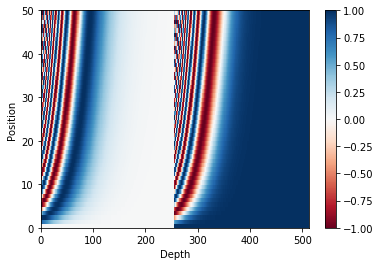

In [18]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Encoder Layer
每个encoder层包含以下sublayers：
1.   Multi-head attention (with padding mask)
2.   2个dense layers跟在dropout后

每个sublayer都有个一个残差连接（residual connection）紧跟在layer normalization后。在深度网络中残差连接可以避免梯度消失问题。


每个sublayer的输出是<code>LayerNorm(x + Sublayer(x))</code>。标准化处理在<code>d_model</code>(last)轴上。

In [0]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

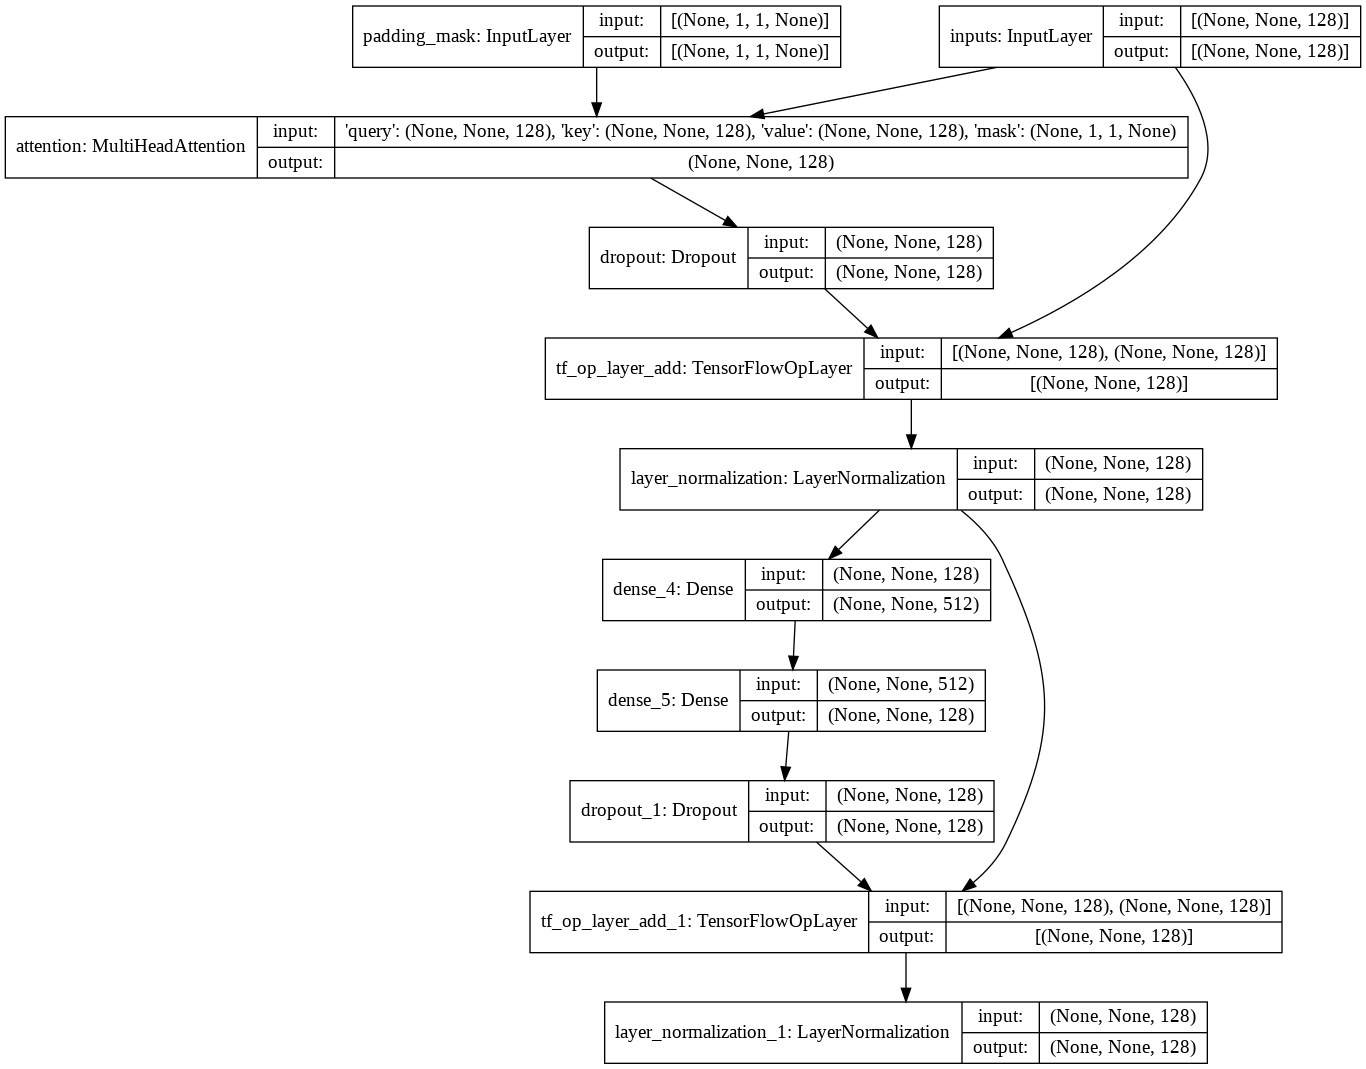

In [20]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder_layer")

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

### Encoder
Encoder包含：
1. Input Embedding
2. Positional Encoding
3. <code>num_layers</code>encoder layers

输入会被转换成embedding然后再加上positional encoding。它们的和是encoder layer的输入。encoder的输出是最后的线性层的输入。

In [0]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

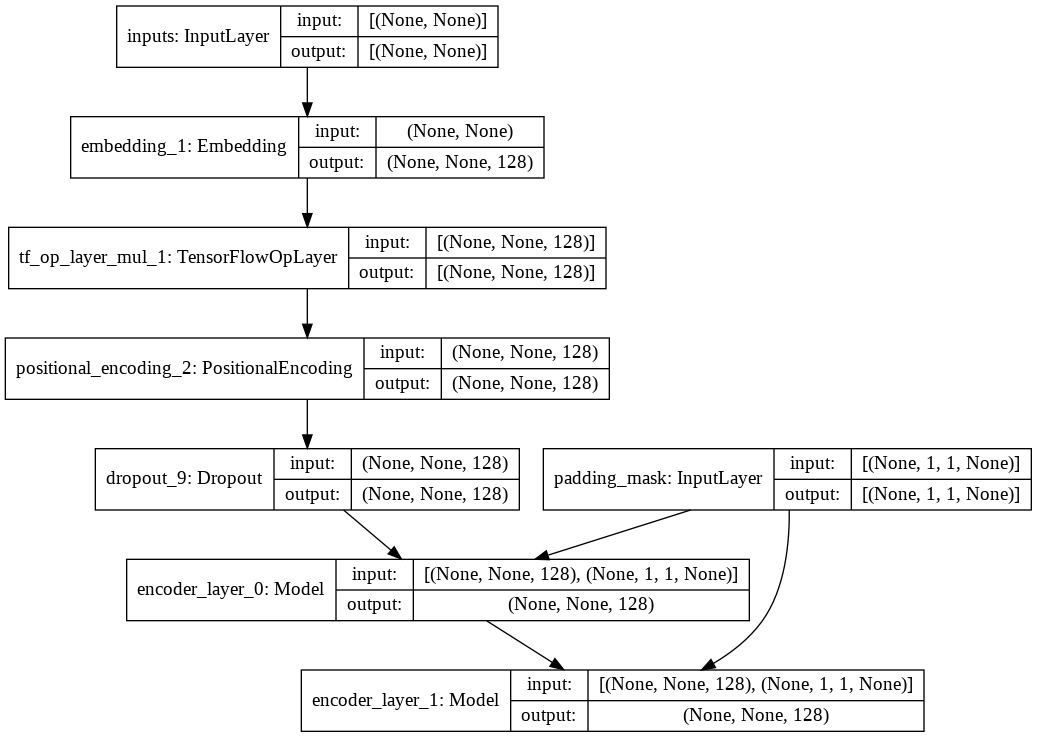

In [30]:
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")

tf.keras.utils.plot_model(
   sample_encoder, to_file='encoder.png', show_shapes=True)

### Decoder Layer
每个decoder layer包含以下sublayers：

1. Masked multi-head attention (with look ahead mask and padding mask)
2. Multi-head attention (with padding mask)。<code>value</code>和<code>key</code>接受encoder的输出作为输入。<code>query</code>则接受Masked multi-head attention sublayer的输出。
3. 2个dense layers跟在dropout后

每个sublayer都有个一个残差连接（residual connection）紧跟在layer normalization后。在深度网络中残差连接可以避免梯度消失问题。

在query接受了decoder的首个attention block的输出后，key会接受encoder的输出，attention权重表示了对于decoder的输出来说，encoder的输出的重要度。换句话说，decoder通过查看encoder的输出和自己输出的self-attention来预测下一个单词。具体可查看上面的scaled dot product attention小节。

In [0]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

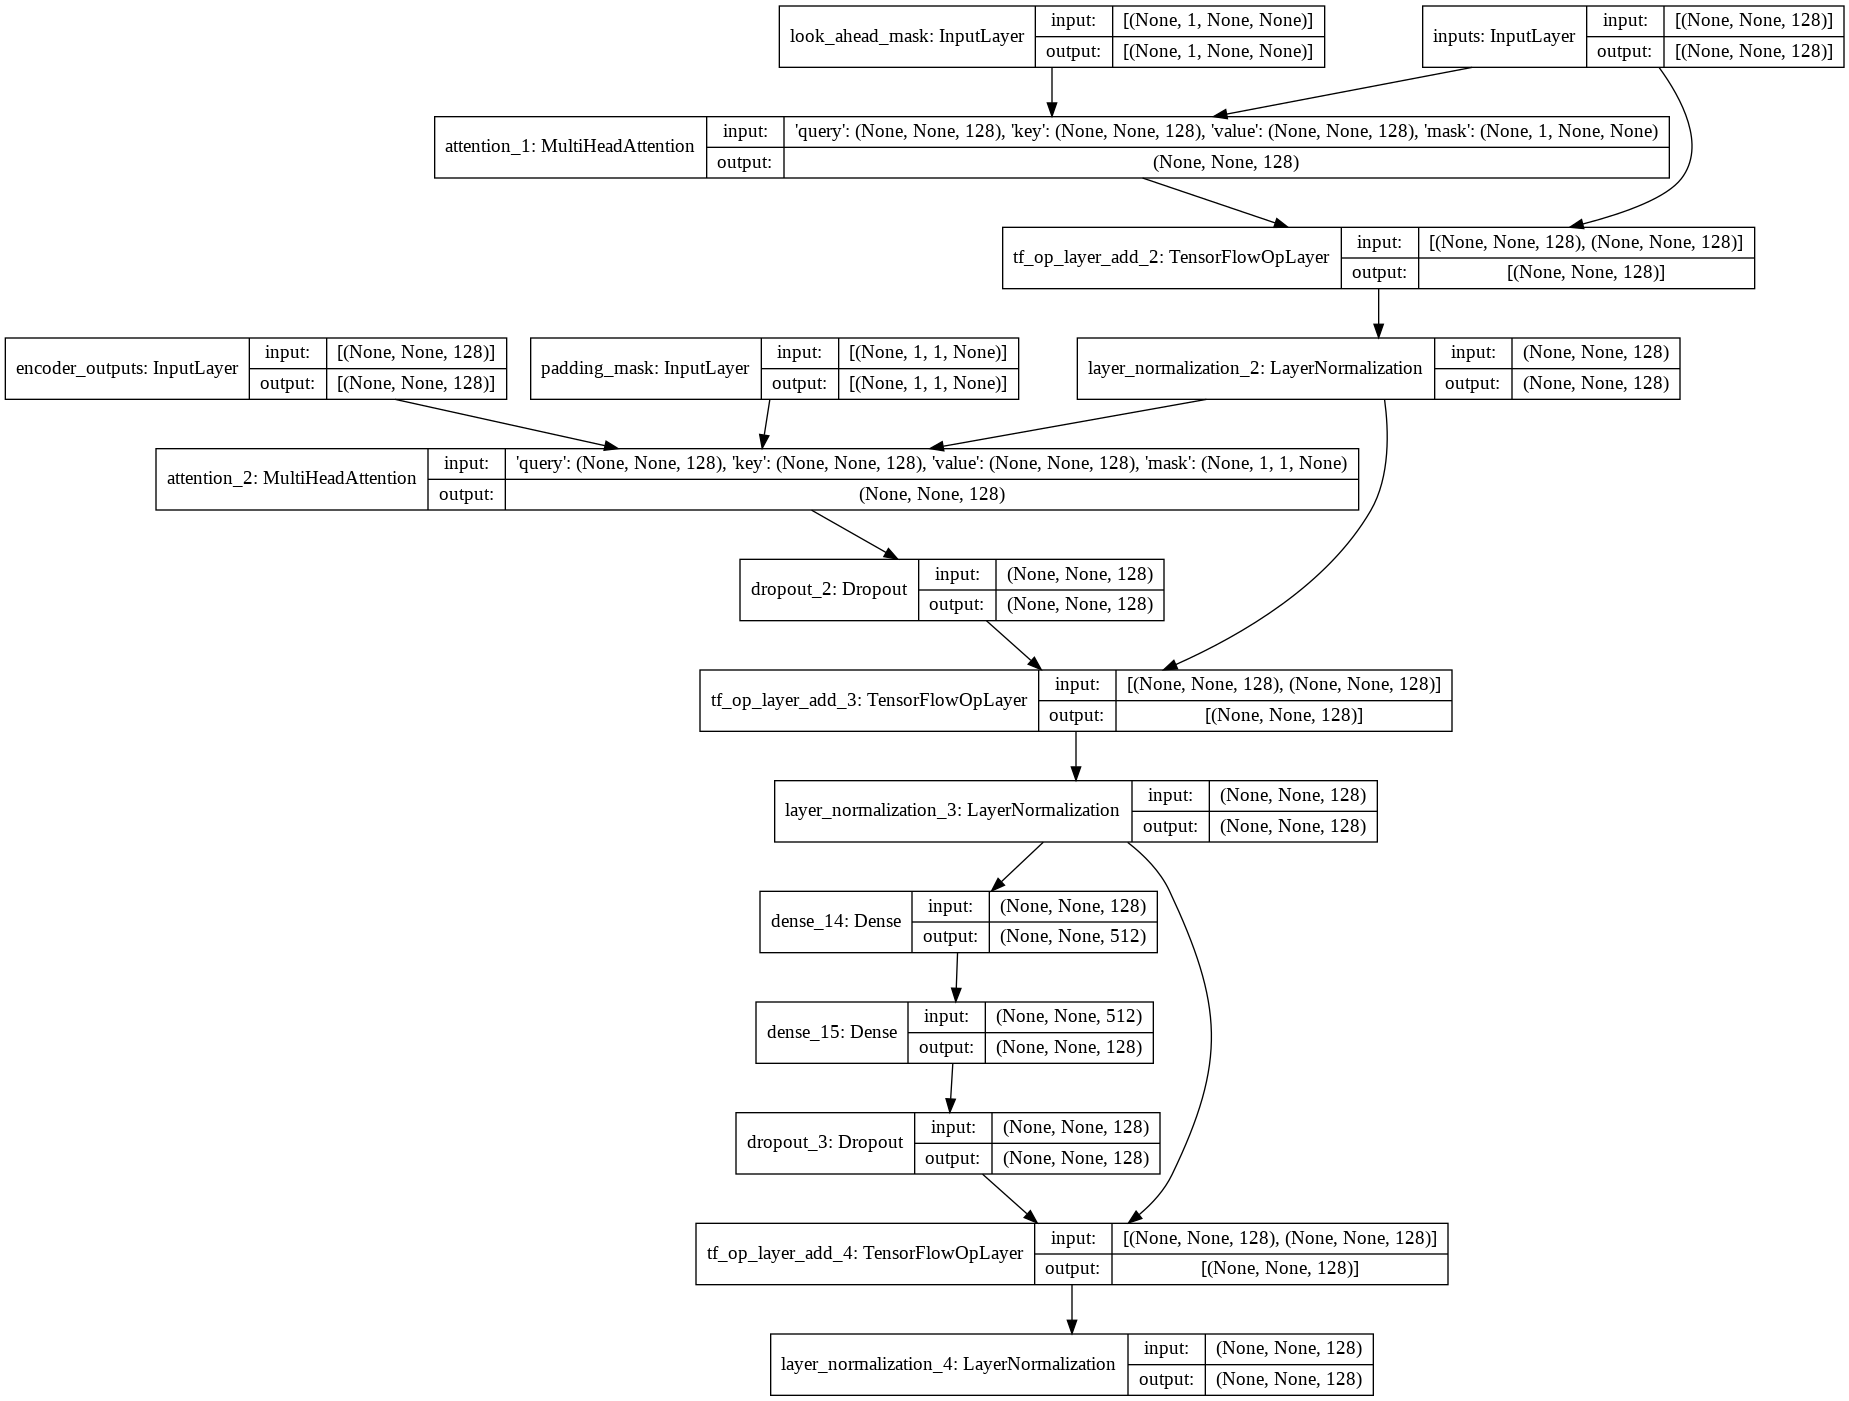

In [22]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

### Decoder
Decoder包含：

1. 输出Embedding
2. Positional Encoding
3. N decoder layers

target会被转换成embedding然后再加上positional encoding。它们的和是decoder layer的输入。decoder的输出是最后的线性层的输入。

In [0]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

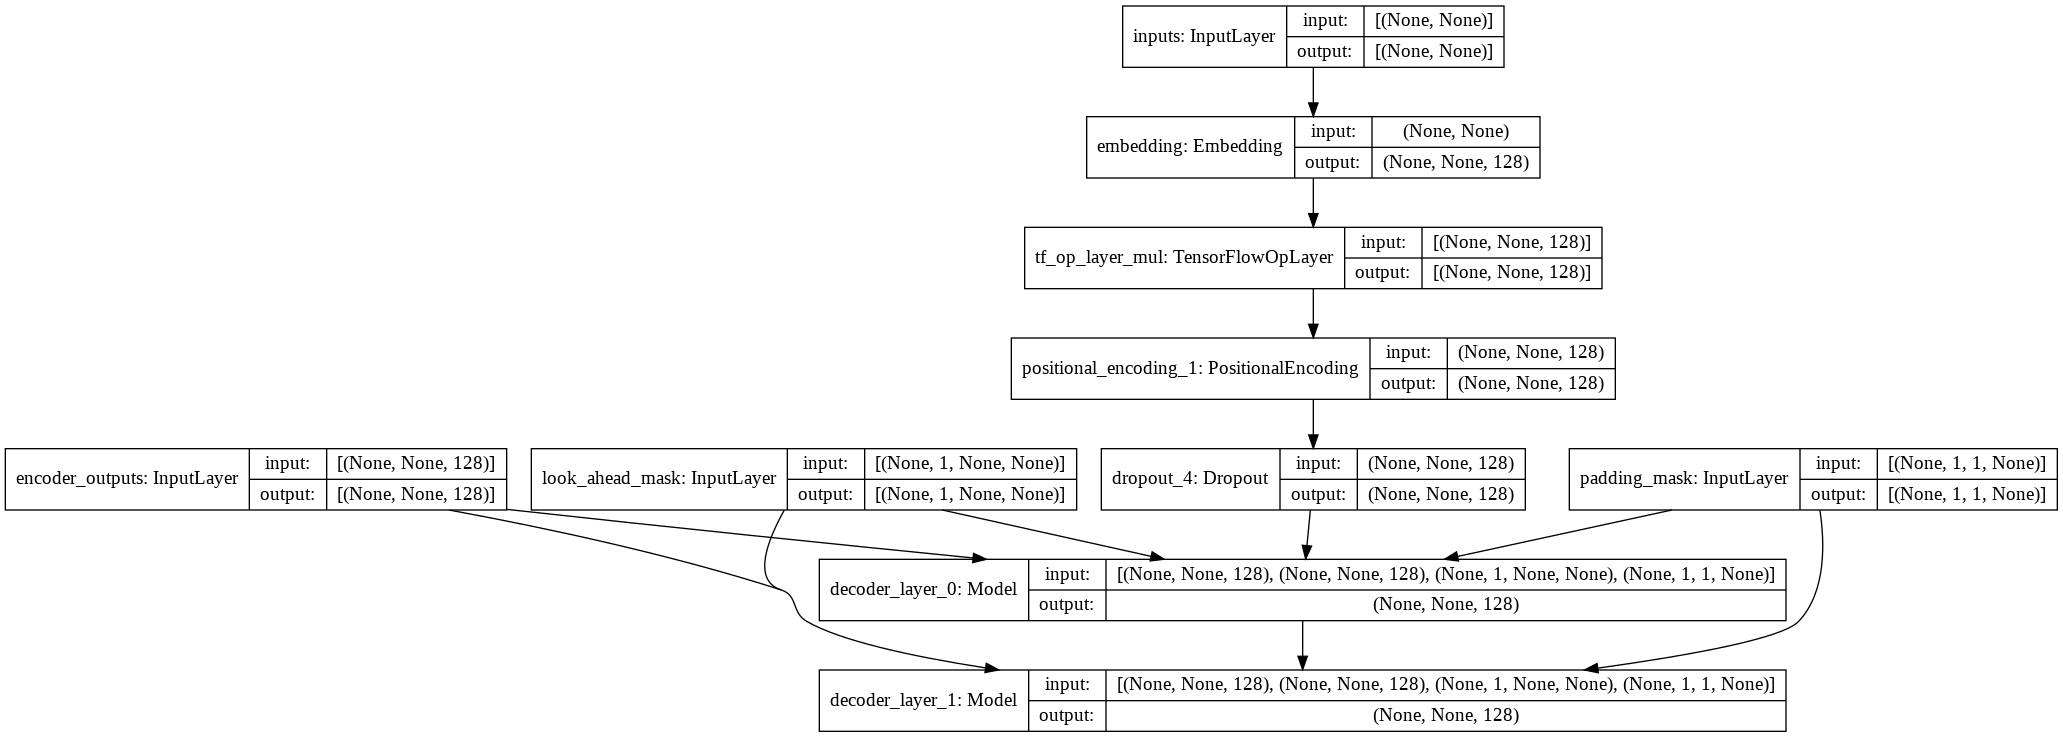

In [25]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

### Transformer
Transformer包含了encoder，decoder和最后的线性层。decoder的输出作为线性层的输入，然后线性层的输出会被返回。

In [0]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
    # 在decoder的首个attention bloc中，mask输入里的未来时刻的token
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
    # 在第二个attention block中mask encoder的输出
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

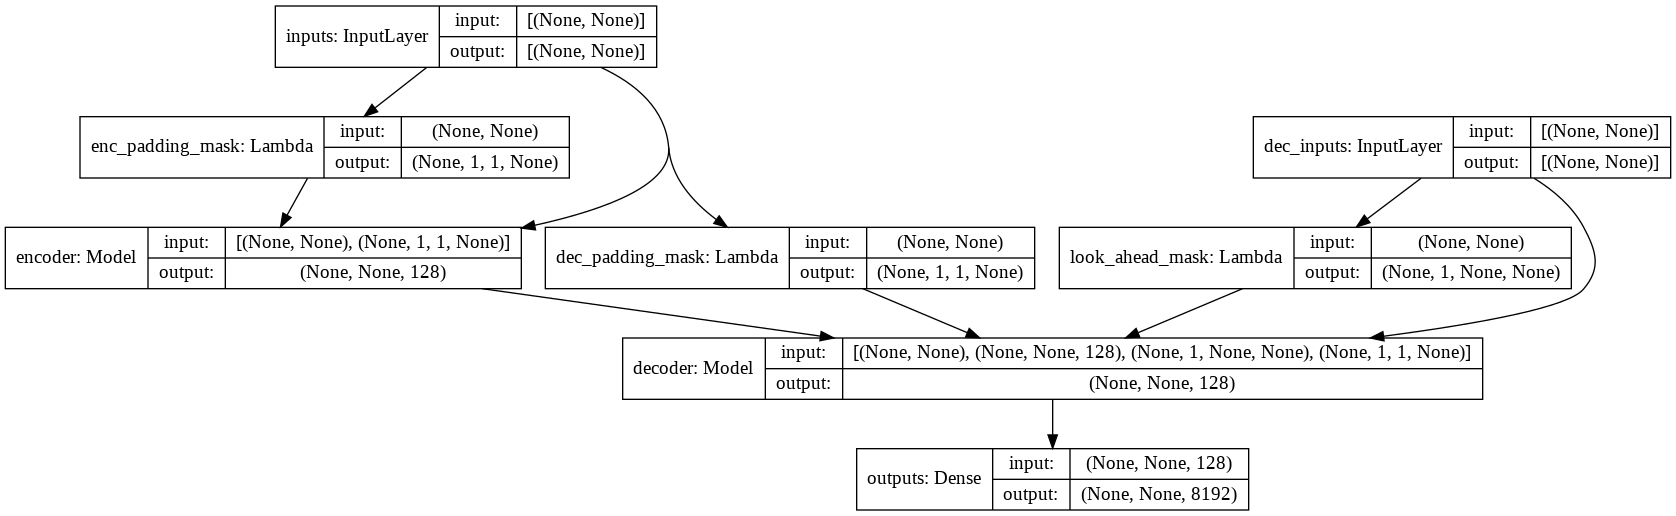

In [32]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

### 训练模型
#### 初始化模型
为了保证教程的简洁性，我们削减了<code>num_layers</code>, <code>d_model</code>和 <code>units</code>的数量。原始版本的transformer可以查看[论文](https://arxiv.org/abs/1706.03762)。

In [0]:
tf.keras.backend.clear_session()

# 超参数
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

### 损失函数
因为我们pad了target序列，所以在计算损失时，应用padding mask是很重要的。

In [0]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### 自定义学习率
我们使用一个自定义学习率变化的Adam optimizer，式子根据[论文](https://arxiv.org/abs/1706.03762)如下：
$$lrate=d^{-0.5}_{model}*min(step\_num^{-0.5},step\_num*warmup\_steps^{-1.5})$$

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

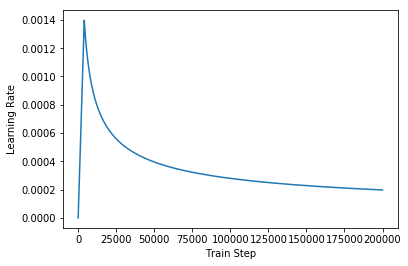

In [37]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 编译模型

In [0]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    # 保证labels的shape为(batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    accuracy = tf.metrics.SparseCategoricalAccuracy()(y_true, y_pred)
    return accuracy

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### Fit模型
训练transformer使用model.fit()

In [39]:
EPOCHS = 20

model.fit(dataset, epochs=EPOCHS)

Epoch 1/20
689/689 [==============================] - 96s 140ms/step - loss: 2.1146 - accuracy: 0.0249
Epoch 2/20
689/689 [==============================] - 82s 118ms/step - loss: 1.5008 - accuracy: 0.0530
Epoch 3/20
689/689 [==============================] - 82s 118ms/step - loss: 1.3941 - accuracy: 0.0652
Epoch 4/20
689/689 [==============================] - 81s 118ms/step - loss: 1.3313 - accuracy: 0.0718
Epoch 5/20
689/689 [==============================] - 81s 117ms/step - loss: 1.2744 - accuracy: 0.0765
Epoch 6/20
689/689 [==============================] - 81s 118ms/step - loss: 1.2229 - accuracy: 0.0801
Epoch 7/20
689/689 [==============================] - 81s 118ms/step - loss: 1.1670 - accuracy: 0.0832
Epoch 8/20
689/689 [==============================] - 81s 117ms/step - loss: 1.1056 - accuracy: 0.0861
Epoch 9/20
689/689 [==============================] - 81s 117ms/step - loss: 1.0496 - accuracy: 0.0890
Epoch 10/20
689/689 [==============================] - 81s 117ms/step - l

### 评价和预测
以下步骤用于验证：
* 对输入序列应用我们之前创建数据集时定义的的预处理手法
* 对输入序列进行分词并添加<code>START_TOKEN， END_TOKEN</code>
* 计算padding mask和look ahead mask。
* decoder通过看encoder的输出和它自己的输出来预测
* 选择最后一个词，计算其argmax
* 将预测的单词结合传给decoder作为decoder的输入
* 我们的方法中，decoder根据前一时刻预测的单词来预测下时刻的单词

注意：我们的模型的capcity较小（削减了层以及次元）并且只用了一小部分数据集进行训练，所以模型的表现还能被进一步改善。

In [0]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        # 在seq_len次元上选择最后一个词
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 如何预测的id是end_token时返回结果
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 结合output和预测的id，这将会传递给decoder
        # 作为其输入.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)


def predict(sentence):
    prediction = evaluate(sentence)

    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence

让我们来测试我们的模型！

In [41]:
output = predict('Where have you been?')

Input: Where have you been?
Output: i m a little fast .


In [42]:
output = predict("It's a trap")

Input: It's a trap
Output: i ll be right back .


In [43]:
# 将模型的预测用作其输入
sentence = 'I am not crazy, my mother had me tested.'
for _ in range(5):
    sentence = predict(sentence)
    print('')

Input: I am not crazy, my mother had me tested.
Output: what do you mean ?

Input: what do you mean ?
Output: i don t know . i don t know . i m a little pressed .

Input: i don t know . i don t know . i m a little pressed .
Output: you re a good man , dr . jones .

Input: you re a good man , dr . jones .
Output: i m not sure . i m not gonna win or something .

Input: i m not sure . i m not gonna win or something .
Output: you re gonna tell me that little girl s got that way .



### 总结
我们通过TensorFlow 2.0使用了约500行的代码实现了Transformer模型。

在这个教程中，我们关注两种不同的方法：Functional API和Model subclassing，并结合它们来创建复杂模型。

尝试使用不同的数据集和超参数来训练Transformer吧！感谢阅读。